**Visualization of Result Output**

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define column names
columns = [
    'precision', 'recall', 'f1_score', 'execution_time', 'threshold',
    'two_step', 'bleu_1', 'bleu_2', 'bleu_3', 'bleu_4',
    'prompt_token_count', 'candidates_token_count', 'total_token_count',
    'total_calls', 'tp', 'fp', 'fn'
]

# Create an empty DataFrame
df = pd.DataFrame(columns=columns)

In [3]:
categories=["Beauty", "Electronics", "Fashion", "Jewellery"]
for cat in categories:
    path=f"../where_not_data/results_output_{cat}.csv"
    data=pd.read_csv(path)
    print(data.shape)
    # Add values to df by summing element-wise
    df = df.add(data, fill_value=0)


(19, 17)
(19, 17)
(19, 17)
(19, 17)


In [4]:
# Iterate over each row to compute values
for index, row in df.iterrows():
    df.at[index, 'precision'] = row['tp'] / (row['tp'] + row['fp']) if (row['tp'] + row['fp']) != 0 else 0
    df.at[index, 'recall'] = row['tp'] / (row['tp'] + row['fn']) if (row['tp'] + row['fn']) != 0 else 0
    df.at[index, 'f1_score'] = (2 * df.at[index, 'precision'] * df.at[index, 'recall']) / (df.at[index, 'precision'] + df.at[index, 'recall']) if (df.at[index, 'precision'] + df.at[index, 'recall']) != 0 else 0
    
    # Compute average values
    for division in ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4', 'execution_time', 'threshold']:
        df.at[index, division] = row[division] / len(categories)
    
    # Convert two_step to boolean
    if row['two_step'] == len(categories):
        df.at[index, 'two_step'] = True
    elif row['two_step'] == 0:
        df.at[index, 'two_step'] = False

In [5]:
data=df

/tmp/ipykernel_125818/2573156789.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_zero_shot['threshold'] = pd.to_numeric(data_zero_shot['threshold'], errors='coerce')
/tmp/ipykernel_125818/2573156789.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_zero_shot['recall'] = pd.to_numeric(data_zero_shot['recall'], errors='coerce')
/tmp/ipykernel_125818/2573156789.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

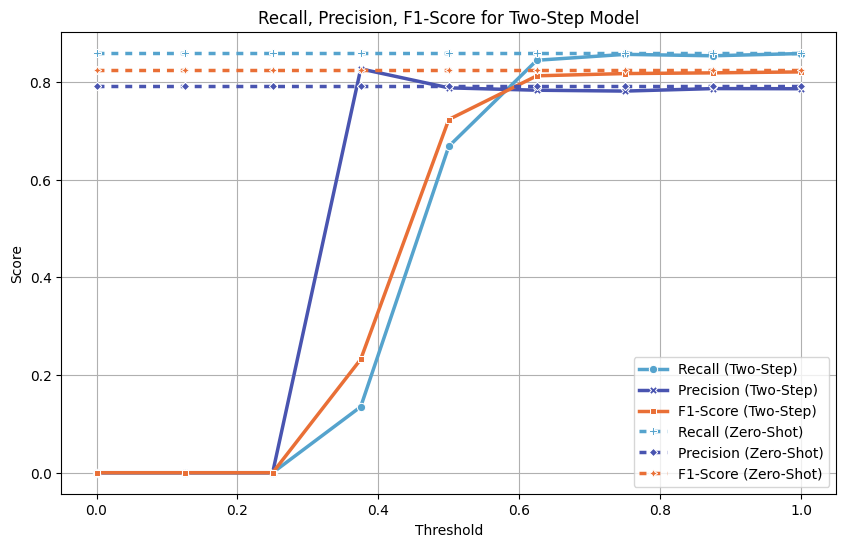

In [6]:
data_true = data[data['two_step'] == True]
data_zero_shot = data[pd.isna(data['two_step'])]


# Sort by threshold for proper line plotting
data_true = data_true.sort_values('threshold')

# Generate colors using the specified palette
palette = sns.color_palette("icefire", 6)
recall_color, precision_color, f1_color = palette[0], palette[1], palette[5]  # Pick well-separated colors

# Convert threshold and metric columns to numeric, forcing errors to NaN if conversion fails
data_true['threshold'] = pd.to_numeric(data_true['threshold'], errors='coerce')
data_zero_shot['threshold'] = pd.to_numeric(data_zero_shot['threshold'], errors='coerce')
data_zero_shot['recall'] = pd.to_numeric(data_zero_shot['recall'], errors='coerce')
data_zero_shot['precision'] = pd.to_numeric(data_zero_shot['precision'], errors='coerce')
data_zero_shot['f1_score'] = pd.to_numeric(data_zero_shot['f1_score'], errors='coerce')

# Drop any NaN values that resulted from non-convertible values
data_true = data_true.dropna(subset=['threshold'])
data_zero_shot = data_zero_shot.dropna(subset=['threshold', 'recall', 'precision', 'f1_score'])

# Perform interpolation
recall_zero_shot_interp = np.interp(data_true['threshold'], data_zero_shot['threshold'], data_zero_shot['recall'])
precision_zero_shot_interp = np.interp(data_true['threshold'], data_zero_shot['threshold'], data_zero_shot['precision'])
f1_zero_shot_interp = np.interp(data_true['threshold'], data_zero_shot['threshold'], data_zero_shot['f1_score'])

# Extend the thresholds to include 1.0
thresholds_extended = np.append(data_true['threshold'], 1.0)

# Interpolate the values to match the new threshold of 1.0
recall_zero_shot_interp_extended = np.append(recall_zero_shot_interp, np.interp(1.0, data_zero_shot['threshold'], data_zero_shot['recall']))
precision_zero_shot_interp_extended = np.append(precision_zero_shot_interp, np.interp(1.0, data_zero_shot['threshold'], data_zero_shot['precision']))
f1_zero_shot_interp_extended = np.append(f1_zero_shot_interp, np.interp(1.0, data_zero_shot['threshold'], data_zero_shot['f1_score']))

# Create a DataFrame for Seaborn with the extended data
plot_data = pd.concat([
    pd.DataFrame({'Threshold': thresholds_extended, 'Score': np.append(data_true['recall'], data_true['recall'].values[-1]), 'Metric': 'Recall (Two-Step)'}),
    pd.DataFrame({'Threshold': thresholds_extended, 'Score': np.append(data_true['precision'], data_true['precision'].values[-1]), 'Metric': 'Precision (Two-Step)'}),
    pd.DataFrame({'Threshold': thresholds_extended, 'Score': np.append(data_true['f1_score'], data_true['f1_score'].values[-1]), 'Metric': 'F1-Score (Two-Step)'}),
    pd.DataFrame({'Threshold': thresholds_extended, 'Score': recall_zero_shot_interp_extended, 'Metric': 'Recall (Zero-Shot)'}),
    pd.DataFrame({'Threshold': thresholds_extended, 'Score': precision_zero_shot_interp_extended, 'Metric': 'Precision (Zero-Shot)'}),
    pd.DataFrame({'Threshold': thresholds_extended, 'Score': f1_zero_shot_interp_extended, 'Metric': 'F1-Score (Zero-Shot)'})
])

# Define custom colors for each metric
custom_palette = {
    'Recall (Two-Step)': recall_color,
    'Precision (Two-Step)': precision_color,
    'F1-Score (Two-Step)': f1_color,
    'Recall (Zero-Shot)': recall_color,
    'Precision (Zero-Shot)': precision_color,
    'F1-Score (Zero-Shot)': f1_color
}

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_data, 
    x='Threshold', 
    y='Score', 
    hue='Metric', 
    style='Metric',
    linewidth=2.5, 
    markers=True, 
    dashes={'Recall (Two-Step)': '', 'Precision (Two-Step)': '', 'F1-Score (Two-Step)': '', 
            'Recall (Zero-Shot)': (2, 2), 'Precision (Zero-Shot)': (2, 2), 'F1-Score (Zero-Shot)': (2, 2)},
    palette=custom_palette  # Apply custom colors
)

# Plot settings
plt.xlabel('Threshold')
#plt.xlim(0.125, 0.75)  # Ensure the lower bound is 0.5 and the upper bound is 1.0
plt.ylabel('Score')
plt.title('Recall, Precision, F1-Score for Two-Step Model')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig('../saved_plots/where_not_two_step_vs_zero_shot.png', dpi=300, bbox_inches='tight')
plt.show()

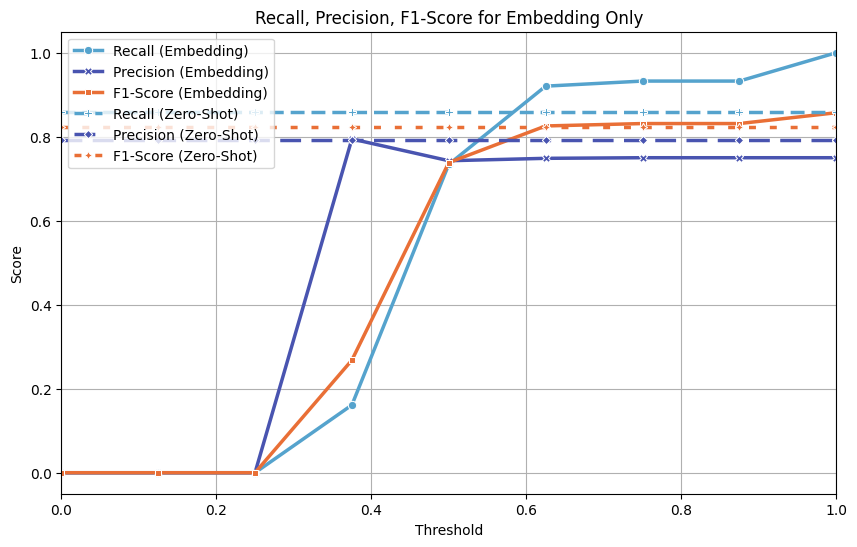

In [7]:
# Filter rows where 'two_step' is False
data_false = data[data['two_step'] == False]

# Sort by threshold for proper line plotting
data_false = data_false.sort_values('threshold')

# Append 1.0 to the f1_score at the last index of data_false
f1_extended = np.append(data_false['f1_score'].values, 1.0)

# Interpolate zero-shot values to match data_false threshold points
recall_zero_shot_interp = np.interp(data_false['threshold'], data_zero_shot['threshold'], data_zero_shot['recall'])
precision_zero_shot_interp = np.interp(data_false['threshold'], data_zero_shot['threshold'], data_zero_shot['precision'])
f1_zero_shot_interp = np.interp(data_false['threshold'], data_zero_shot['threshold'], data_zero_shot['f1_score'])

# Create a DataFrame for Seaborn plotting
plot_data = pd.concat([
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': data_false['recall'], 'Metric': 'Recall (Embedding)'}),
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': data_false['precision'], 'Metric': 'Precision (Embedding)'}),
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': data_false['f1_score'], 'Metric': 'F1-Score (Embedding)'}),
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': recall_zero_shot_interp, 'Metric': 'Recall (Zero-Shot)'}),
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': precision_zero_shot_interp, 'Metric': 'Precision (Zero-Shot)'}),
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': f1_zero_shot_interp, 'Metric': 'F1-Score (Zero-Shot)'})
])

# Define custom colors for each metric
custom_palette = {
    'Recall (Embedding)': recall_color,
    'Precision (Embedding)': precision_color,
    'F1-Score (Embedding)': f1_color,
    'Recall (Zero-Shot)': recall_color,
    'Precision (Zero-Shot)': precision_color,
    'F1-Score (Zero-Shot)': f1_color
}


# Custom dash patterns for Zero-Shot
custom_dashes = {
    'Recall (Embedding)': '', 
    'Precision (Embedding)': '', 
    'F1-Score (Embedding)': '', 
    'Recall (Zero-Shot)': (4, 2),  # Adjusted dashes for Zero-Shot Recall
    'Precision (Zero-Shot)': (6, 3),  # Adjusted dashes for Zero-Shot Precision
    'F1-Score (Zero-Shot)': (2, 4)  # Adjusted dashes for Zero-Shot F1
}

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_data, 
    x='Threshold', 
    y='Score', 
    hue='Metric', 
    style='Metric',
    linewidth=2.5,  # Increased line thickness for better visibility
    markers=True,  # Markers at each point
    dashes=custom_dashes,  # Custom dash styles for Zero-Shot
    palette=custom_palette  # Apply custom colors
)

# Plot settings
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, F1-Score for Embedding Only')
plt.legend(loc='upper left')
plt.grid(True)
plt.xlim(0,1.0)

# Save the plot in the saved_plots directory
plt.savefig('../saved_plots/where_not_embedding_vs_zero_shot.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Filter rows where 'two_step' is True
data_false = data[data['two_step'] == False]

# Sort by threshold for proper line plotting
data_false = data_false.sort_values('threshold')

data_false



,precision,recall,f1_score,execution_time,threshold,two_step,bleu_1,bleu_2,bleu_3,bleu_4,prompt_token_count,candidates_token_count,total_token_count,total_calls,tp,fp,fn
16,0,0.0,0,20.442334,0.0,False,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2400
1,0,0.0,0,20.44944,0.125,False,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2400
3,0,0.0,0,20.441334,0.25,False,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2400
5,0.794661,0.16125,0.268098,22.054156,0.375,False,0.323362,0.229861,0.202131,0.188639,0,0,0,0,387,100,2013
7,0.742833,0.734167,0.738474,21.882365,0.5,False,0.8296,0.748834,0.717237,0.698966,0,0,0,0,1762,610,638
9,0.74856,0.920417,0.82564,21.856577,0.625,False,0.946734,0.877674,0.847849,0.82933,0,0,0,0,2209,742,191
11,0.75,0.9325,0.831352,21.83051,0.75,False,0.953597,0.884118,0.853947,0.834529,0,0,0,0,2238,746,162
13,0.75,0.9325,0.831352,21.735031,0.875,False,0.953597,0.884118,0.853947,0.834529,0,0,0,0,2238,746,162
18,0.75,1.0,0.857143,22.268841,1.0,False,0.953597,0.884118,0.853947,0.834529,0,0,0,0,2238,746,0


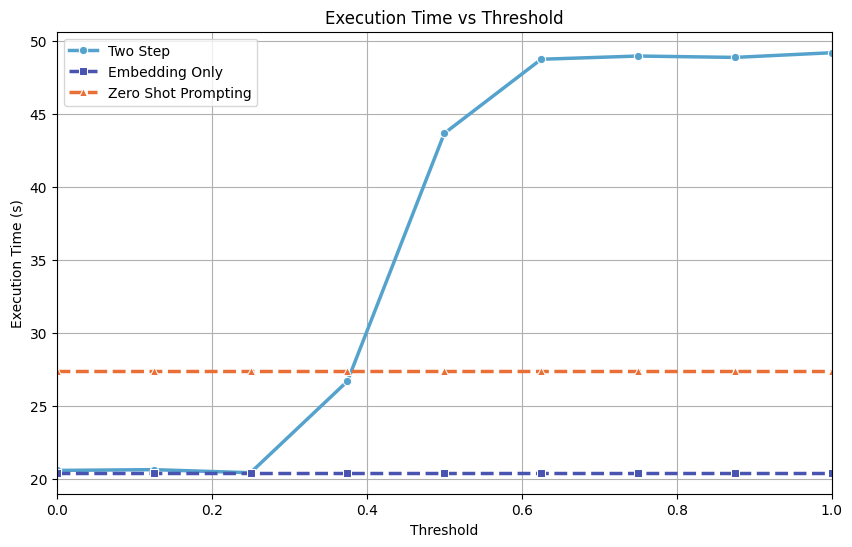

In [9]:
thresholds = data_true['threshold'].values
# Extend thresholds to 1.0
thresholds_extended = np.append(thresholds, 1.0)
# Extract execution time for "Zero Shot" (assumed single value for Zero-Shot data)
execution_time_zero_shot = data_zero_shot['execution_time'].values[0]  # Extract single value

# Create an array of repeated values for zero-shot execution time
execution_time_zero_shot_line = np.full(len(thresholds), execution_time_zero_shot)

# Create an array for "Embedding Only" execution time (also assumed to be a single value for Embedding Only data)
execution_time_embedding_only = np.full(len(thresholds), data_false['execution_time'].values[0])

# Extend the execution times to include the 1.0 threshold
execution_time_zero_shot_line_extended = np.append(execution_time_zero_shot_line, execution_time_zero_shot)
execution_time_embedding_only_extended = np.append(execution_time_embedding_only, data_false['execution_time'].values[0])


# Extend execution time values to match threshold extension
execution_time_zero_shot_line_extended = np.append(execution_time_zero_shot_line, execution_time_zero_shot)
execution_time_embedding_only_extended = np.append(execution_time_embedding_only, data_false['execution_time'].values[0])


# Interpolate or extend data_true execution time to include 1.0
execution_time_true_extended = np.append(data_true['execution_time'].values, data_true['execution_time'].values[-1]) 

# Plot execution time vs threshold using Seaborn
plt.figure(figsize=(10, 6))

# Plot each line using Seaborn
sns.lineplot(x=thresholds_extended, y=execution_time_true_extended, label='Two Step', marker='o', color=recall_color, linewidth=2.5)
sns.lineplot(x=thresholds_extended, y=execution_time_embedding_only_extended, label='Embedding Only', marker='s', linestyle="--", color=precision_color, linewidth=2.5)
sns.lineplot(x=thresholds_extended, y=execution_time_zero_shot_line_extended, label='Zero Shot Prompting', marker='^', linestyle='--', color=f1_color, linewidth=2.5)

# Plot a vertical dotted line at the intersection threshold
#plt.axvline(x=0.45, linestyle=':', color='black', linewidth=1)

# Plot settings
plt.xlabel('Threshold')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Threshold')
plt.legend(loc='upper left')
plt.grid(True)

# Ensure x-axis starts at 0.5 and ends at 1.0
plt.xlim(0, 1.0)

# Save the plot
plt.savefig('../saved_plots/where_not_execution_times_emb_zero_two_step.png')
plt.show()

In [10]:
data[data['two_step'] == True]

,precision,recall,f1_score,execution_time,threshold,two_step,bleu_1,bleu_2,bleu_3,bleu_4,prompt_token_count,candidates_token_count,total_token_count,total_calls,tp,fp,fn
0,0,0.0,0,20.639102,0.125,True,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2400
2,0,0.0,0,20.429003,0.25,True,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2400
4,0.826531,0.135,0.232092,26.690251,0.375,True,0.308254,0.211819,0.183299,0.169147,91015,530,91545,530,324,68,2076
6,0.787715,0.667917,0.722886,43.648676,0.5,True,0.797345,0.70931,0.673179,0.652021,430236,2596,432832,2596,1603,432,797
8,0.782844,0.844167,0.81235,48.722045,0.625,True,0.912364,0.834985,0.799694,0.778089,532624,3237,535861,3237,2026,562,374
10,0.781072,0.85625,0.816935,48.942058,0.75,True,0.917137,0.839734,0.804427,0.7821,539192,3280,542472,3280,2055,576,345
12,0.78618,0.853333,0.818382,48.848524,0.875,True,0.915702,0.837482,0.80208,0.778815,539192,3280,542472,3280,2048,557,352
15,0,0.0,0,20.587413,0.0,True,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2400
17,0.785878,0.857917,0.820319,49.168966,1.0,True,0.916549,0.839565,0.804936,0.782483,539192,3280,542472,3280,2059,561,341


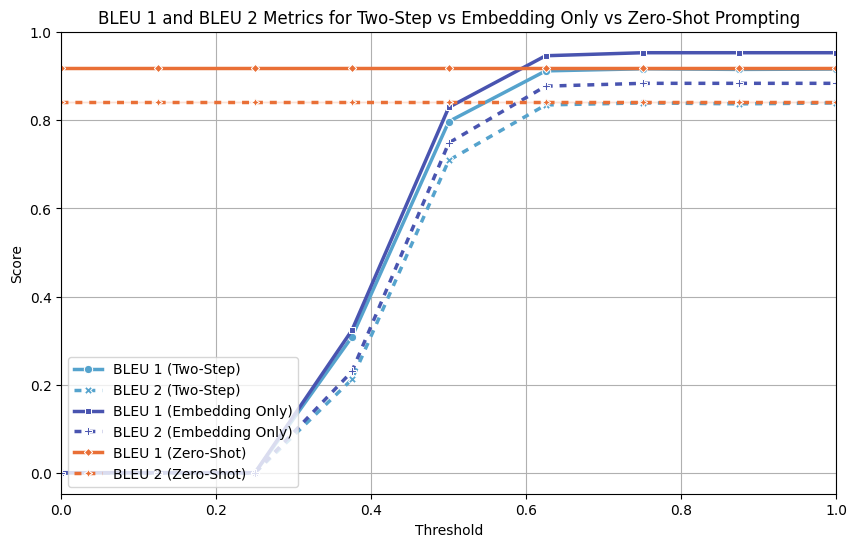

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming data_true, data_false, and data_zero_shot are already defined

# Generate the color palette from seaborn
palette = sns.color_palette("icefire", 6)
precision_color = palette[0]  # BLEU 1 color (Two-Step)
recall_color = palette[1]  # BLEU 2 color (Embedding Only)
f1_color = palette[5]  # BLEU 2 color (Zero-Shot)

# Ensure the columns are numeric
data_true['threshold'] = pd.to_numeric(data_true['threshold'], errors='coerce')
data_zero_shot['threshold'] = pd.to_numeric(data_zero_shot['threshold'], errors='coerce')
data_zero_shot['bleu_1'] = pd.to_numeric(data_zero_shot['bleu_1'], errors='coerce')
data_zero_shot['bleu_2'] = pd.to_numeric(data_zero_shot['bleu_2'], errors='coerce')

# Remove or handle NaN values if necessary
# Option 1: Drop rows with NaNs in key columns
data_true = data_true.dropna(subset=['threshold'])
data_zero_shot = data_zero_shot.dropna(subset=['threshold', 'bleu_1', 'bleu_2'])

# Option 2: Fill NaNs with a default value, for example, 0 (be cautious with this approach)
# data_true = data_true.fillna({'threshold': 0})
# data_zero_shot = data_zero_shot.fillna({'threshold': 0, 'bleu_1': 0, 'bleu_2': 0})

# Now interpolate zero-shot values to match data_true and data_false threshold points
bleu_1_zero_shot_interp_true = np.interp(data_true['threshold'], data_zero_shot['threshold'], data_zero_shot['bleu_1'])
bleu_2_zero_shot_interp_true = np.interp(data_true['threshold'], data_zero_shot['threshold'], data_zero_shot['bleu_2'])
bleu_1_zero_shot_interp_false = np.interp(data_false['threshold'], data_zero_shot['threshold'], data_zero_shot['bleu_1'])
bleu_2_zero_shot_interp_false = np.interp(data_false['threshold'], data_zero_shot['threshold'], data_zero_shot['bleu_2'])



# Combine the additional data with the original plot data
plot_data = pd.concat([
    pd.DataFrame({'Threshold': data_true['threshold'], 'Score': data_true['bleu_1'], 'Metric': 'BLEU 1 (Two-Step)', 'Method': 'Two-Step'}),
    pd.DataFrame({'Threshold': data_true['threshold'], 'Score': data_true['bleu_2'], 'Metric': 'BLEU 2 (Two-Step)', 'Method': 'Two-Step'}),
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': data_false['bleu_1'], 'Metric': 'BLEU 1 (Embedding Only)', 'Method': 'Embedding Only'}),
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': data_false['bleu_2'], 'Metric': 'BLEU 2 (Embedding Only)', 'Method': 'Embedding Only'}),
    pd.DataFrame({'Threshold': data_true['threshold'], 'Score': bleu_1_zero_shot_interp_true, 'Metric': 'BLEU 1 (Zero-Shot)', 'Method': 'Zero-Shot'}),
    pd.DataFrame({'Threshold': data_true['threshold'], 'Score': bleu_2_zero_shot_interp_true, 'Metric': 'BLEU 2 (Zero-Shot)', 'Method': 'Zero-Shot'}),
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': bleu_1_zero_shot_interp_false, 'Metric': 'BLEU 1 (Zero-Shot)', 'Method': 'Zero-Shot'}),
    pd.DataFrame({'Threshold': data_false['threshold'], 'Score': bleu_2_zero_shot_interp_false, 'Metric': 'BLEU 2 (Zero-Shot)', 'Method': 'Zero-Shot'})
])

# Define custom palette for consistency
custom_palette = {
    'BLEU 1 (Two-Step)': precision_color,
    'BLEU 2 (Two-Step)': precision_color,
    'BLEU 1 (Embedding Only)': recall_color,
    'BLEU 2 (Embedding Only)': recall_color,
    'BLEU 1 (Zero-Shot)': f1_color,
    'BLEU 2 (Zero-Shot)': f1_color
}

# Define dash patterns for Zero-Shot and Embedding Only (dashed lines)
dashes_dict = {
    'BLEU 1 (Two-Step)': (),  # Solid line for BLEU 1 (Two-Step)
    'BLEU 1 (Embedding Only)': (),  # Solid line for BLEU 1 (Embedding Only)
    'BLEU 1 (Zero-Shot)': (),  # Solid line for BLEU 1 (Zero-Shot)
    
    'BLEU 2 (Two-Step)': (2,2),  # Solid line for BLEU 2 (Two-Step)
    'BLEU 2 (Embedding Only)': (2, 2),  # Dashed line for BLEU 2 (Embedding Only)
    'BLEU 2 (Zero-Shot)': (2, 2)  # Dashed line for BLEU 2 (Zero-Shot)
}

# Plot using Seaborn
plt.figure(figsize=(10, 6))

# Plot the lines for each metric with respective colors and line styles
sns.lineplot(data=plot_data, x='Threshold', y='Score', hue='Metric', style='Metric', markers=True, 
             linewidth=2.5, palette=custom_palette, dashes=dashes_dict)

# Plot settings
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('BLEU 1 and BLEU 2 Metrics for Two-Step vs Embedding Only vs Zero-Shot Prompting')
plt.legend(loc='lower left')
plt.grid(True)
plt.xlim(0, 1) 
# Save the plot
plt.savefig('../saved_plots/where_not_combined_bleu_metrics.png',dpi=300, bbox_inches='tight')
plt.show()
